In [40]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import os
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import re

# Read and Preprocess images

In [2]:
#read all images with PIL and store in an array
data = []
for dirname, _, filenames in (os.walk('data')):
    for filename in tqdm(sorted(filenames)):
        if (filename.endswith('.jpg')):
            #print (os.path.join(dirname, filename))
            img = PIL.Image.open(os.path.join(dirname, filename)).convert('L')
            data.append(np.asarray(img).astype('float32'))
            del img
data = np.array(data, dtype='object')

100%|██████████| 2048/2048 [00:00<00:00, 3720.36it/s]


In [3]:
def pad_images(images, target_shape):
    padded_images = []

    for image in images:
        old_shape = image.shape
        pad_width = [(0, max(0, new_dim - old_dim)) for old_dim, new_dim in zip(old_shape, target_shape)]
        padded_image = np.pad(image, pad_width, mode='constant', constant_values=0)
        padded_images.append(padded_image)

    return np.array(padded_images)

In [4]:
padded_data = pad_images(data,(256,256))
padded_data = padded_data.reshape(padded_data.shape[0],256,256,1)
padded_data.shape

(2048, 256, 256, 1)

In [5]:
# Transpose to feed into torch model
data_t = np.transpose(padded_data, (0, 3, 1, 2))

In [6]:
X = data_t.copy()/255
y = pd.read_csv('label.csv')['label'].values
del padded_data
del data_t
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
del X, y
torch.cuda.empty_cache()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#define data loaders
train_data = torch.utils.data.TensorDataset(torch.from_numpy(X_train).to(device=device, dtype=torch.float), torch.from_numpy(y_train).to(device=device, dtype=torch.float))
#val_data = torch.utils.data.TensorDataset(torch.from_numpy(X_val).to(device=device, dtype=torch.float), torch.from_numpy(y_val).to(device=device, dtype=torch.float))
test_data = torch.utils.data.TensorDataset(torch.from_numpy(X_test).to(device=device, dtype=torch.float), torch.from_numpy(y_test).to(device=device, dtype=torch.float))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=60, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_data, batch_size=25, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

del X_train, y_train, train_data, test_data

torch.cuda.empty_cache()


# Model Construction

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Define the Regression Model
class RegressionModel(nn.Module):
    def __init__(self, resnet_backbone, num_classes=1):
        super(RegressionModel, self).__init__()
        self.resnet = resnet_backbone
        # Modify the first layer to accept 1 channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.Mish(),
            nn.Linear(256, 64),
            nn.Mish(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        features = self.resnet(x)
        output = self.linear_layers(features)
        return output

# Load the pre-trained ResNet model
resnet = models.resnet50(pretrained=True)

# Create the regression model with ResNet as the backbone
regression_model = RegressionModel(resnet)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(regression_model.parameters(), lr=0.001)

# Training loop
num_epochs =200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model.to(device)
train_loss = []
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    val_loss = []

    for images, targets in train_loader:
        regression_model.train()
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = regression_model(images)
        loss = criterion(outputs.squeeze(), targets.float()) 
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        #validate
        regression_model.eval()
        total_val_loss = 0
        #with torch.no_grad():
        #    for images, targets in val_loader:
        #        images, targets = images.to(device), targets.to(device)
        #        outputs = regression_model(images)
        #        loss = criterion(outputs.squeeze(), targets.float())
        #        total_val_loss += loss.item()
        #    avg_val_loss = total_val_loss / len(val_loader) 
    #val_loss.append(avg_val_loss)
    train_loss.append(total_loss / len(train_loader))

    


    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")
    #print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {avg_val_loss/len(val_loader)}")


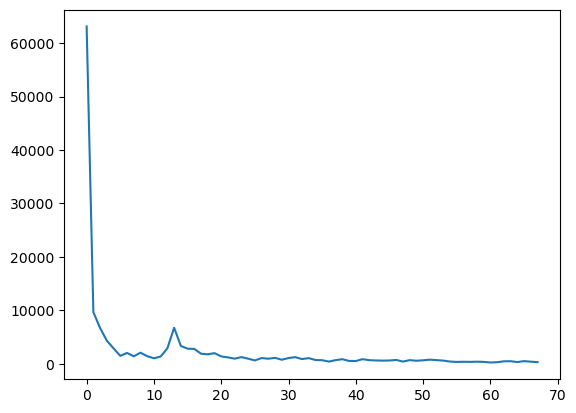

In [9]:
#plt.plot(val_loss, label='Validation loss')
plt.plot(train_loss, label='Training loss')

In [15]:
regression_model.eval()
total_test_loss = 0
yhat = []
y = []
with torch.no_grad():
    for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)
        outputs = regression_model(images)
        yhat.append(outputs.squeeze().cpu().numpy().tolist())
        y.append(targets.cpu().numpy().tolist())
        loss = criterion(outputs.squeeze(), targets.float())  
        total_test_loss += loss.item()

avg_test_loss = np.sqrt(total_test_loss / len(test_loader))
print(f"Test RMSE: {avg_test_loss}")

y = np.array(y, dtype=object)
yhat = np.array(yhat , dtype=object)
y = np.concatenate(y)
#yhat = np.concatenate(yhat)

/home/luizf/miniconda3/envs/neuralforecast/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test RMSE: 15.688572635821453


In [18]:
df = pd.DataFrame(columns=['yhat', 'y'])
df['yhat'] = yhat
df['y'] = y
df.sort_values(by=['y'], inplace=True)

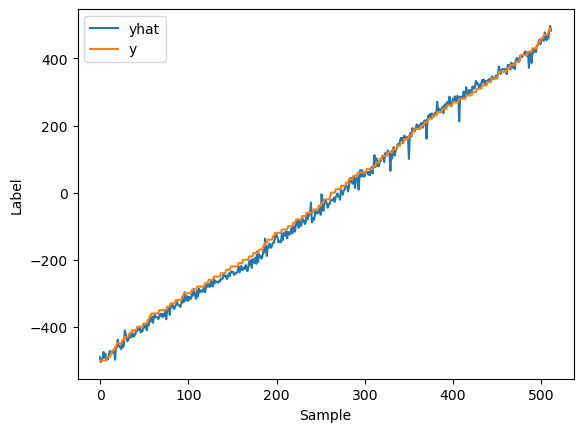

In [19]:
plt.plot(df['yhat'].values)
plt.plot(df['y'].values)
plt.xlabel('Sample')
plt.ylabel('Label')
plt.legend(['yhat', 'y'])
plt.show()

In [20]:
df

yhat      y
213 -490.367096 -500.0
282 -504.517029 -500.0
278 -496.578949 -500.0
431 -493.047028 -500.0
105 -474.804657 -500.0
..          ...    ...
482  469.225494  470.0
421  459.356354  480.0
400  482.661224  480.0
215  496.810333  490.0
511   482.93454  490.0

[512 rows x 2 columns]

# Test with the new video data

In [22]:
del train_loader
del test_loader
torch.cuda.empty_cache()

In [58]:
#read all images with PIL and store in an array
data = []
for dirname, _, filenames in (os.walk('test_data')):
    for filename in tqdm(sorted(filenames, key=lambda x: int(re.sub('\D', '', x)))):
        if (filename.endswith('.jpg')):
            #print (os.path.join(dirname, filename))
            img = PIL.Image.open(os.path.join(dirname, filename)).convert('L')
            data.append(np.asarray(img).astype('float32'))
            del img
data = np.array(data)/255

100%|██████████| 884/884 [00:00<00:00, 21701.62it/s]


In [50]:
padded_data = pad_images(data,(256,256))
padded_data = padded_data.reshape(padded_data.shape[0],256,256,1)
data_t = np.transpose(padded_data, (0, 3, 1, 2))
data_t = torch.from_numpy(data_t).to(device)

In [51]:
dl = DataLoader(data_t, batch_size=40, shuffle=False)

In [52]:
yhats = []
imgs = []
for i in dl:
    yhat = regression_model (i)
    imgs.append(i.detach().cpu().numpy())
    yhats.append(yhat.detach().cpu().numpy())
    del yhat
    torch.cuda.empty_cache()

In [53]:
yhats = np.concatenate(yhats)
imgs = np.concatenate(imgs)

In [54]:
imgs = np.transpose(imgs, (0,2,3,1))

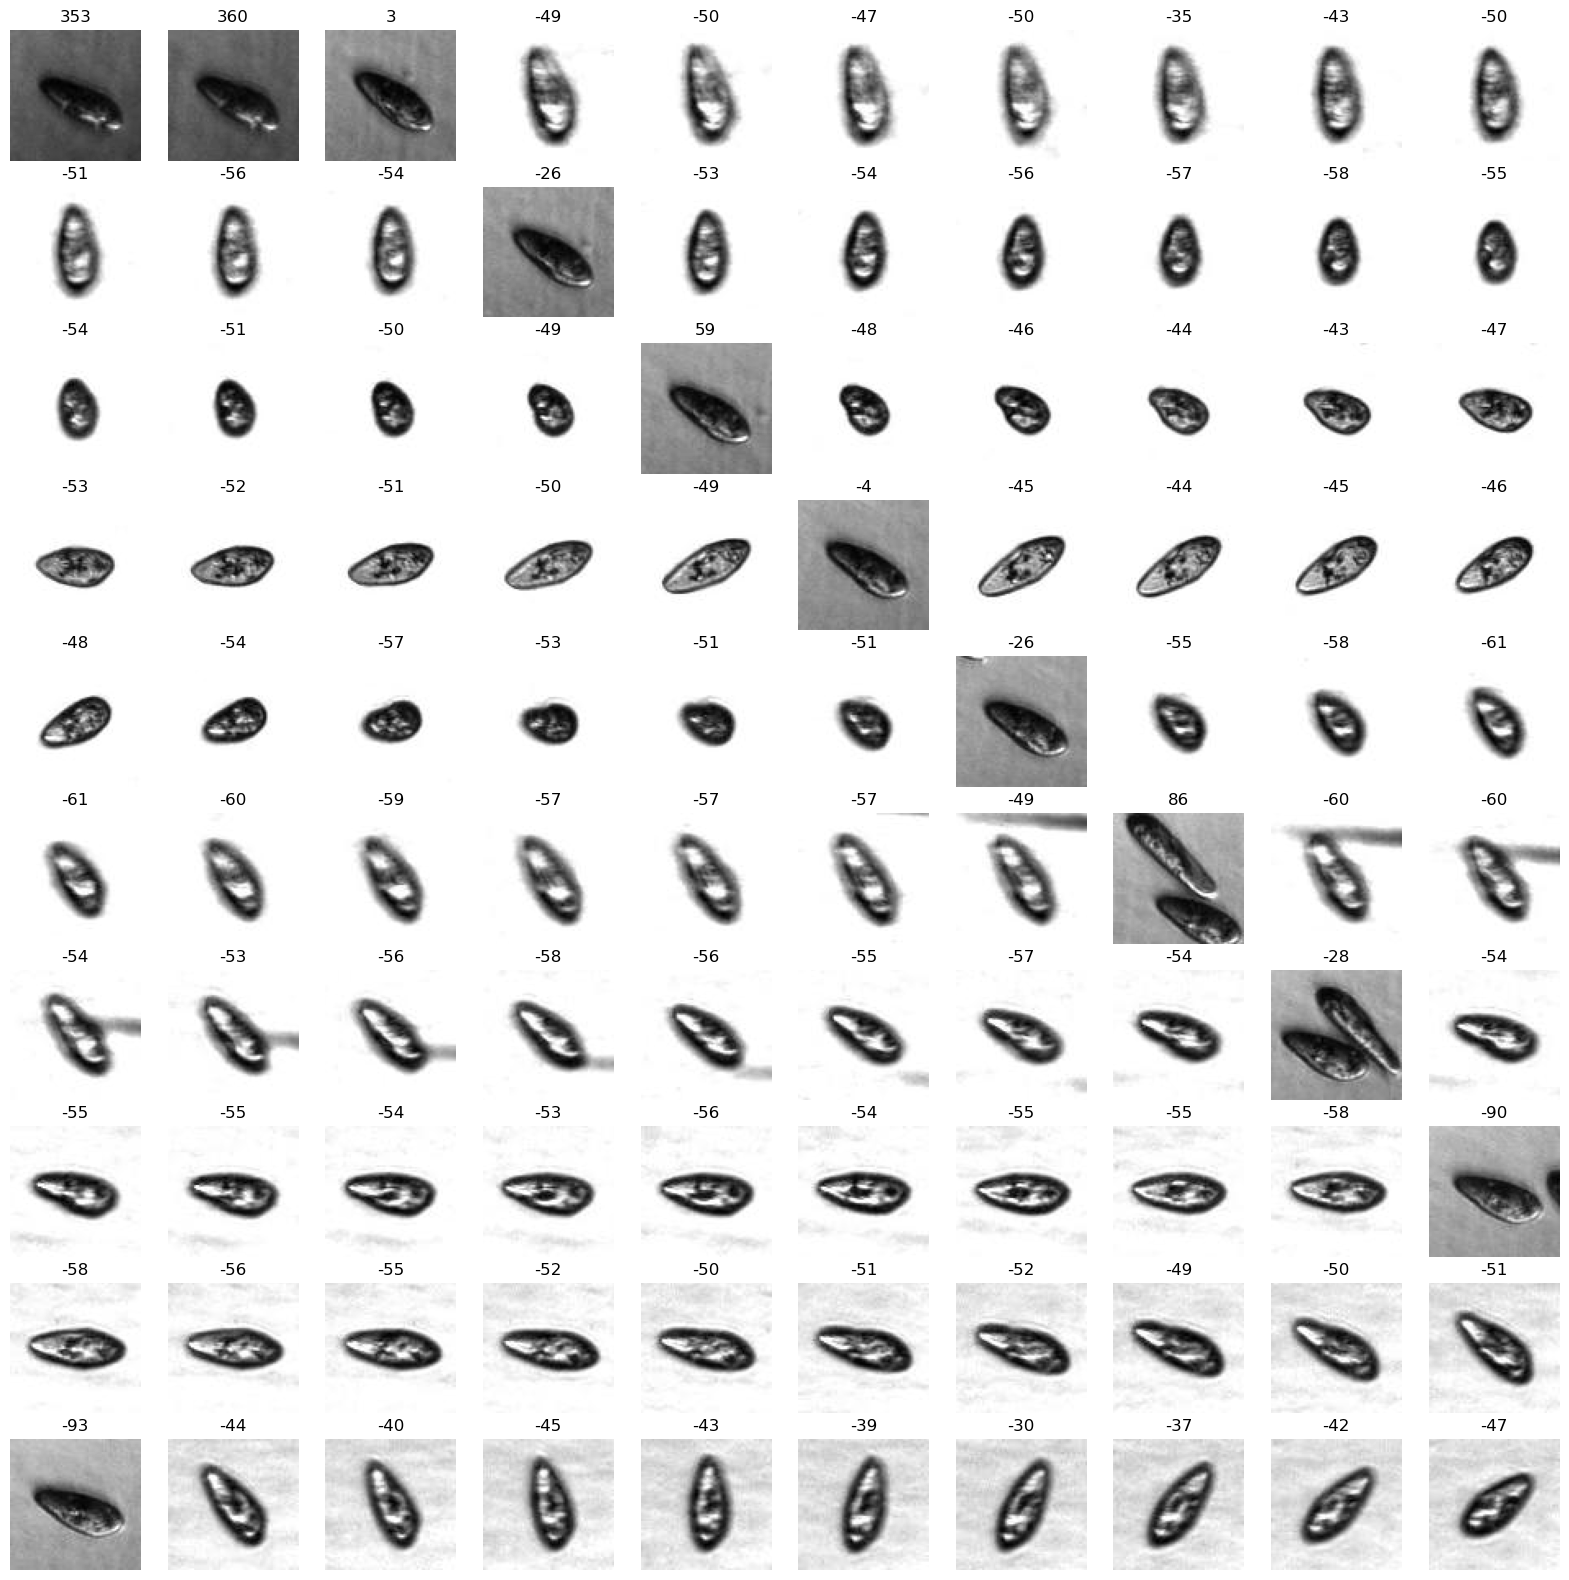

In [55]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(100):
    ax[i//10, i%10].imshow(imgs[i, :80, :80], cmap='gray')
    ax[i//10, i%10].set_title(int(yhats[i]))
    ax[i//10, i%10].axis('off')

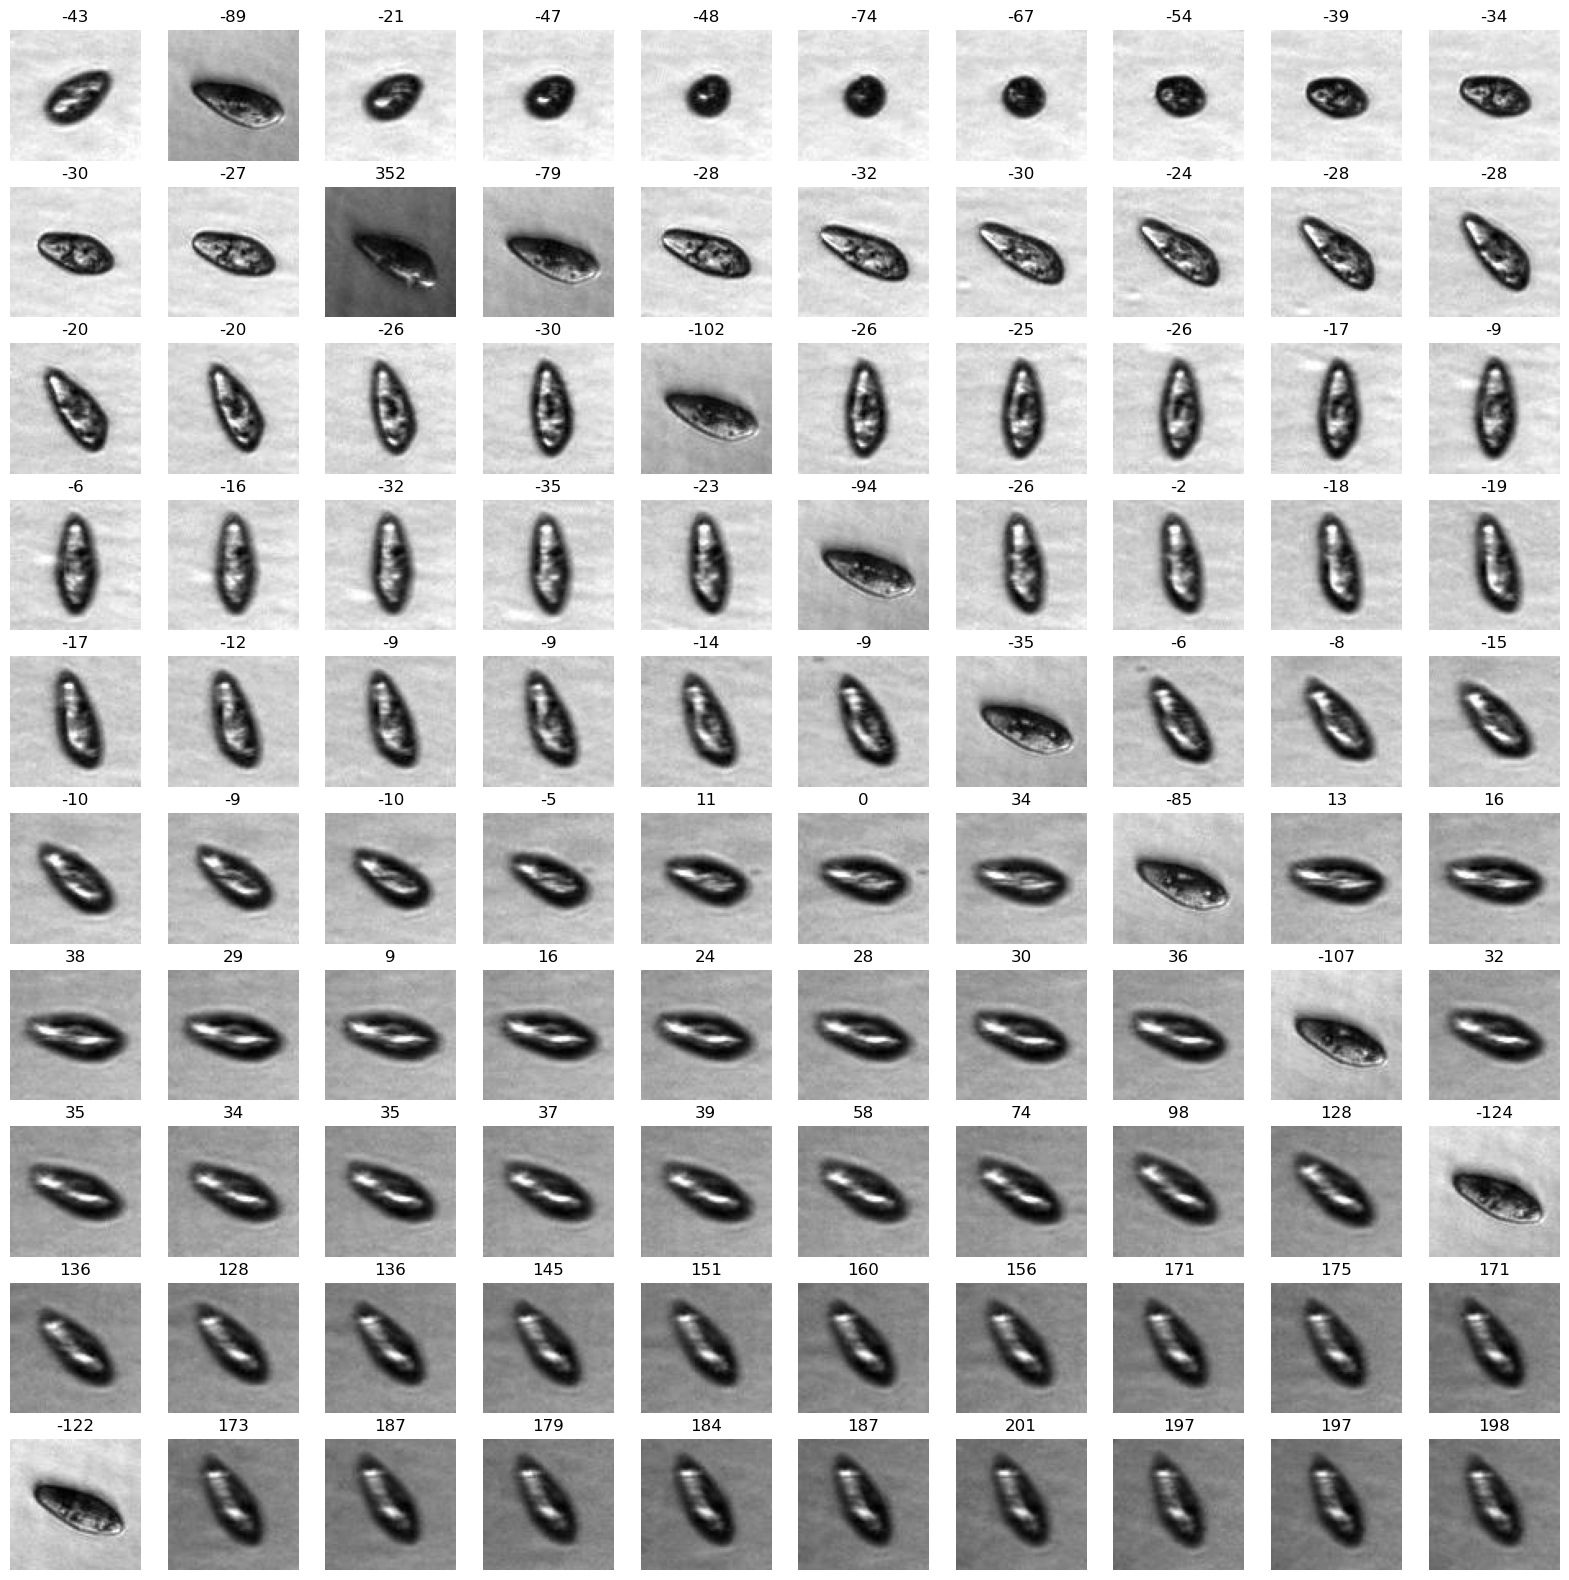

In [56]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i,j in enumerate(range(100, 200)):
    ax[i//10, i%10].imshow(imgs[j, :80, :80], cmap='gray')
    ax[i//10, i%10].set_title(int(yhats[j]))
    ax[i//10, i%10].axis('off')

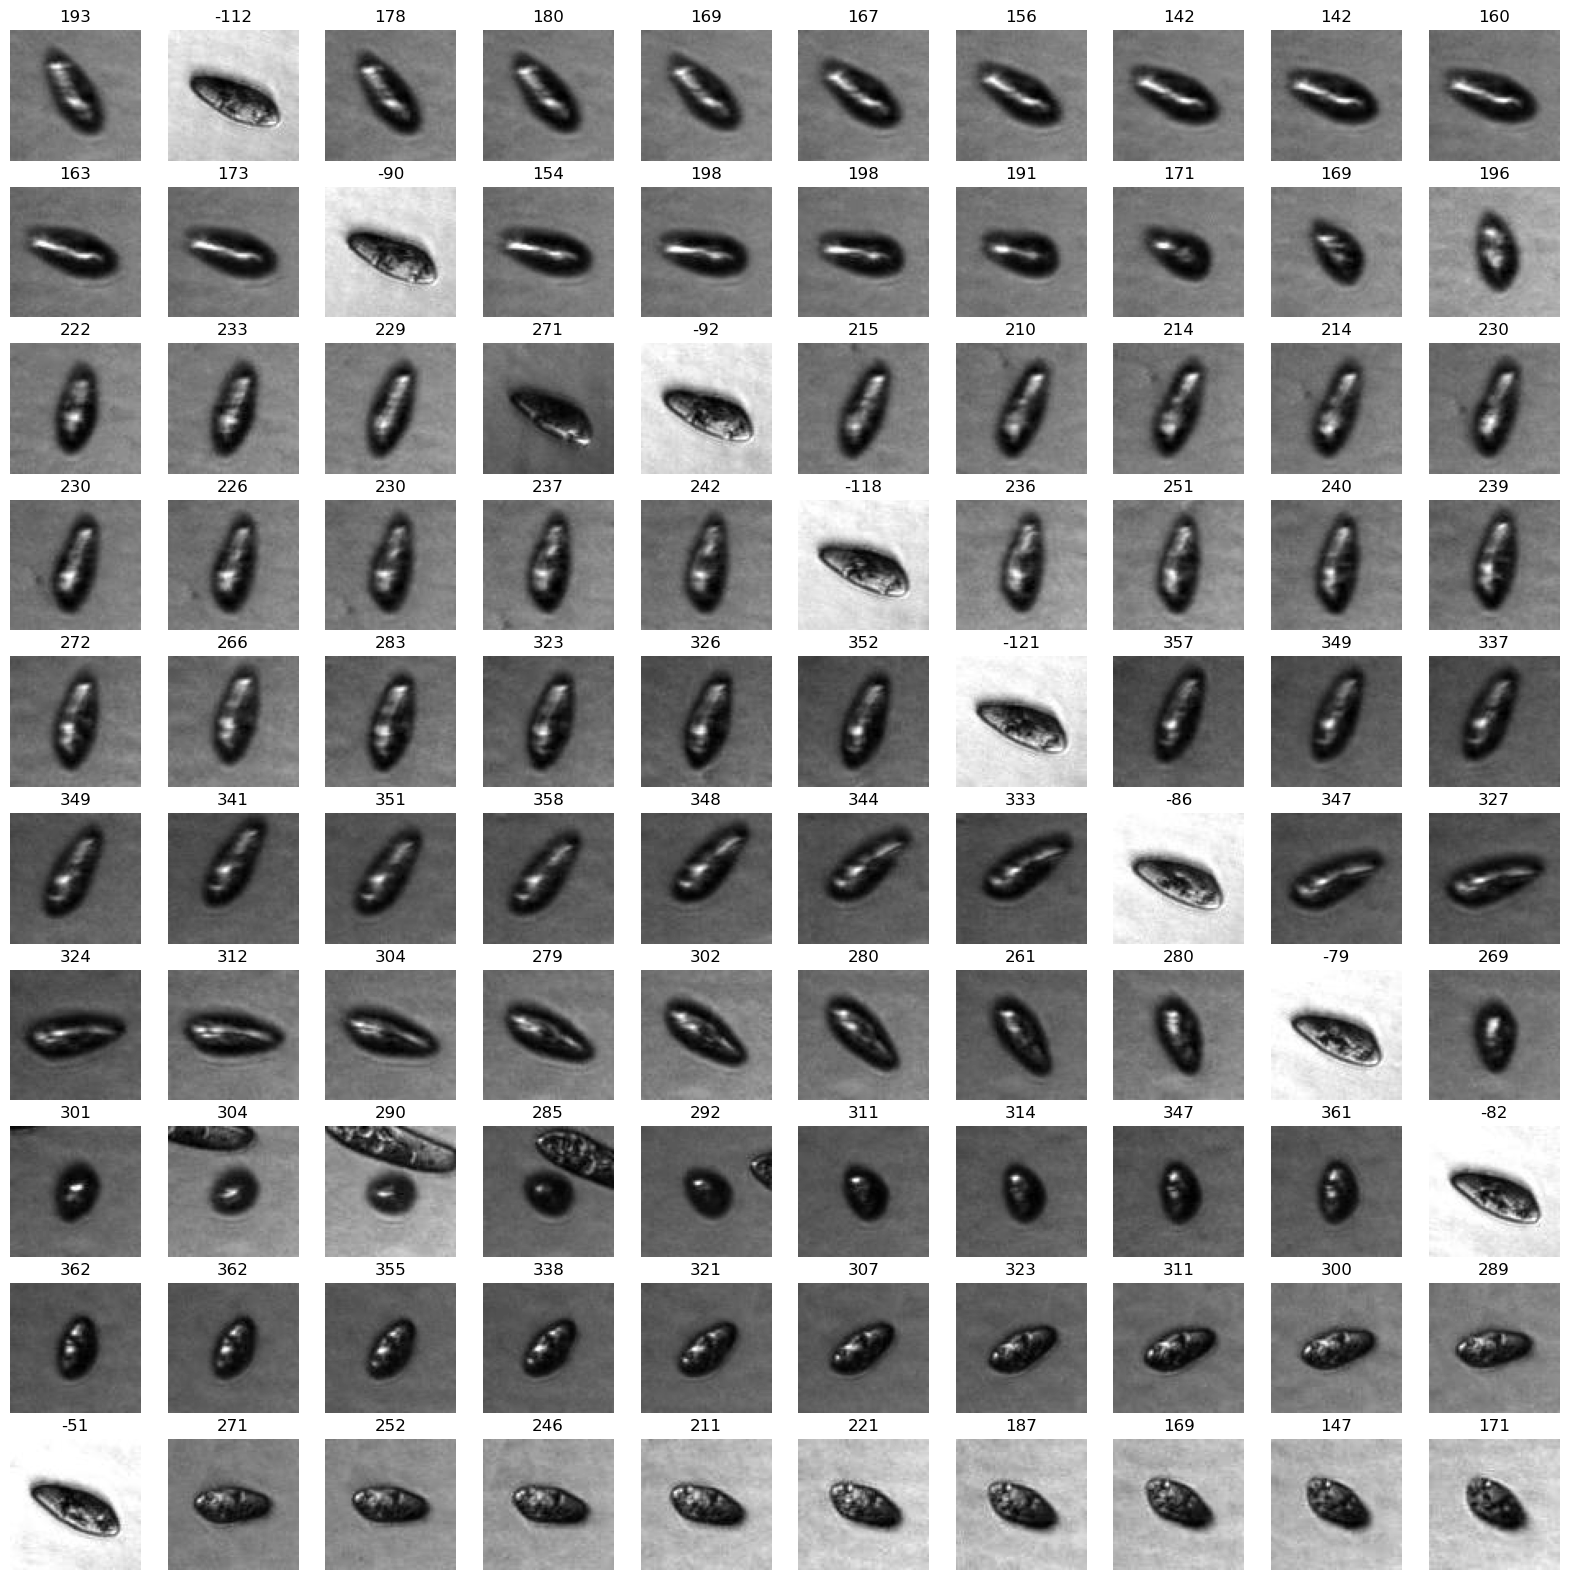

In [59]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i,j in enumerate(range(200, 300)):
    ax[i//10, i%10].imshow(imgs[j, :80, :80], cmap='gray')
    ax[i//10, i%10].set_title(int(yhats[j]))
    ax[i//10, i%10].axis('off')

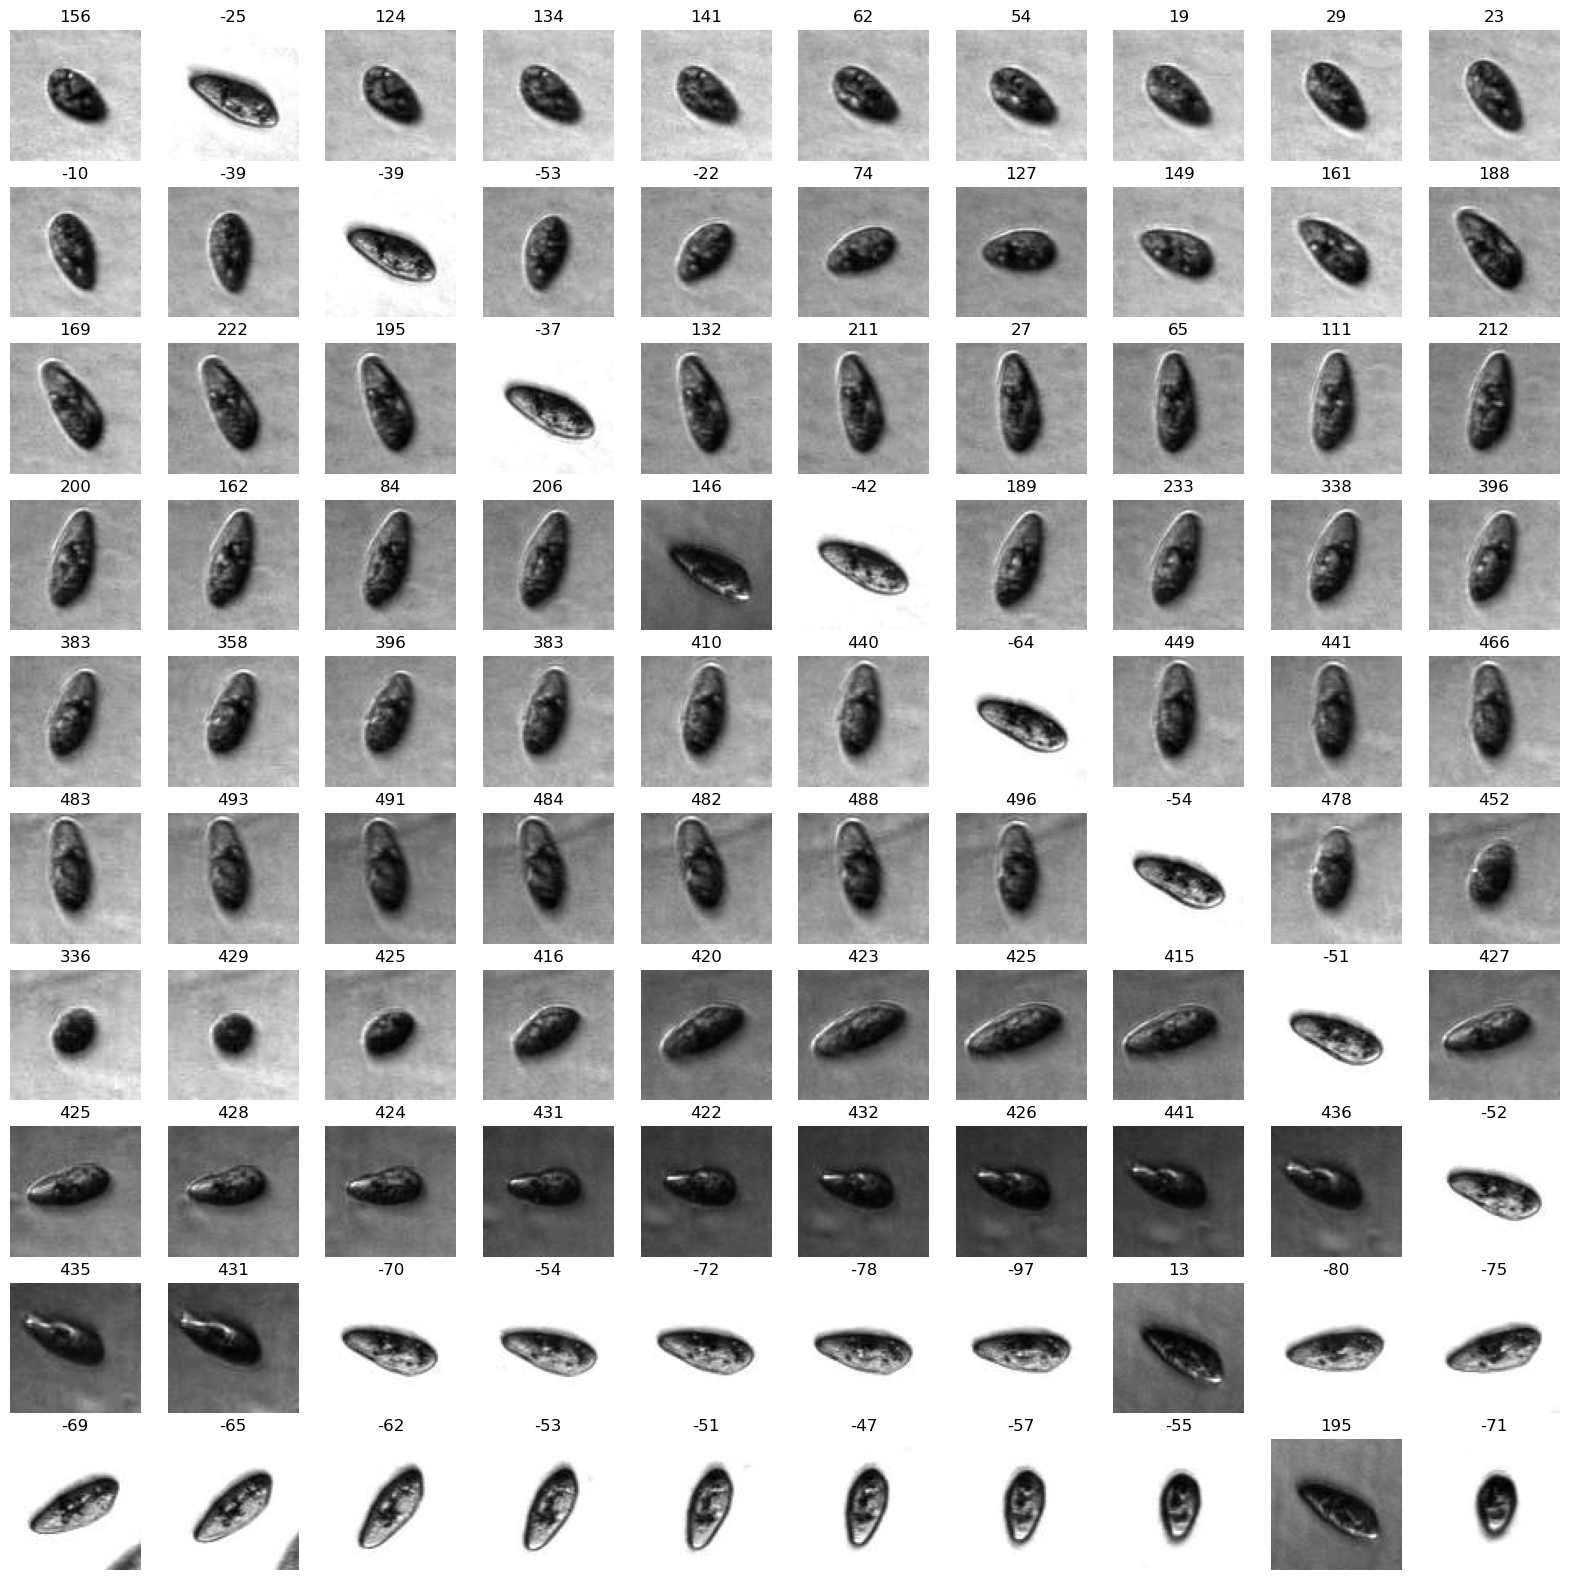

In [60]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i,j in enumerate(range(300, 400)):
    ax[i//10, i%10].imshow(imgs[j, :80, :80], cmap='gray')
    ax[i//10, i%10].set_title(int(yhats[j]))
    ax[i//10, i%10].axis('off')

In [61]:
#Save yhats to txt
np.savetxt("yhat.txt", yhats, fmt="%s")